# Permutation Importance Documentation

This notebook demonstrates how to use`mintpy` to compute predictor ranking using single-pass and multiple-pass permutation importance and plot the results. In the first set of examples, two tree-based models (random forest and gradient-boosting) and logistic regression from scikit-learn were trained on road surface temperature data from Handler et al. (2020). The goal is to predict whether road surface temperatures will be above or below freezing (32 F) in the next hour. This dataset has 100 K examples with a class skew of 39%.

A second set of examples shows that the package is also compatable with regression-based problems as well. 
In those examples, we are using a single random forest trained on the California housing dataset available in scikit-learn. 

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)

In [2]:
import mintpy
import plotting_config 

### Loading the training data and pre-fit models for the classification problem

In [3]:
model_objs, model_names = mintpy.load_models()
examples, targets = mintpy.load_data()

print(f'Examples Shape : {examples.shape}')
print(f'Target Skew : {targets.mean()*100}%')

Examples Shape : (100000, 30)
Target Skew : 39.173%


# InterpretToolkit

The primary component of `mintpy` is the `InterpretToolkit`, which houses the computations and plotting for all the interpretability method contained within. 

To initialize `InterpretToolkit`, requires: 

* a pre-fit model object (or multiple models) in one of the following formats: 
    * a single pre-fit model object
    * list of pre-fit model objects
    * A dict of model objects with model names as the key
* examples and targets (to evaluate the model on)
    * Can be `pandas.DataFrame` or `numpy.array`. If use an array, however, then you must provide the feature names (`'feature_names'`)

If you pass a list of model objects (as we have done), then you must specify the names of the objects (as strings) using `model_names` (used for plotting purposes).  

In [4]:
print(f'model_objs : {model_objs}\nmodel_names : {model_names}')

model_objs : [RandomForestClassifier(min_samples_leaf=5, n_estimators=200, n_jobs=5), GradientBoostingClassifier(), LogisticRegression(C=1)]
model_names : ['Random Forest', 'Gradient Boosting', 'Logistic Regression']


In [5]:
myInterpreter = mintpy.InterpretToolkit(models=model_objs,
                                 model_names=model_names,
                                 examples=examples,
                                 targets=targets,
                                )

OrderedDict([('Random Forest', RandomForestClassifier(min_samples_leaf=5, n_estimators=200, n_jobs=5)), ('Gradient Boosting', GradientBoostingClassifier()), ('Logistic Regression', LogisticRegression(C=1))]) ['Random Forest', 'Gradient Boosting', 'Logistic Regression']


## Permutation Importance

Predictor ranking is often a first step in model interpretability and a popular model-agnostic approach is the permutation importance method. For permutation importance, for each predictor, that predictor's data is permuted (shuffled) and the permuted predictor causing the greatest loss of skill (based on some error metric) is deemed the most important (and each predictor is ranked subsequently). This describes what is known as the single-pass permuation importance method (McGovern et al. 2019; Fig 1. @ https://permutationimportance.readthedocs.io/en/latest/methods.html#permutation-importance for an illustration). The more reliable method, however, is the multi-pass permutation method (Lakshmanan et al. 2015, JOAT; see Fig.2 @ the above link) where the top predictor remains permuting before assessing the second most important predictor, and so on for the third predictor and beyond. `mintpy` uses a stripped-down version of the python package `PermutationImportance` to compute the both single and multipass permutation importance (see https://permutationimportance.readthedocs.io/en/latest/ for additional details). 

`mintpy.permutation_importance` requires the following args:
* `n_vars`, the number of predictor to compute for the multi-pass method.
* `evaluation_fn`, the error function used to assess loss of skill.
    * `mintpy` has 5 built-in error metrics for evaluating predictor importance: 
        * Area under the Curve (`'auc'`)
        * Area under the Precision-Recall Curve (`'aupdrc'`)
        * Normalized Area under the Performance Diagram Curve (`'norm_aupdc'`)
        * Brier Skill Score (`'bss'`)
        * Mean Square Error (`'mse'`) 
* `n_bootstrap`, number of times to repeat the calcuations for confidence intervals
* `subsample`, can be a float between 0-1 as percentage of the examples or an integer for an exact number of random samples to use. 
* `n_jobs`, number of processor to run the script on.
    * Could be the exact number or percentage of the total available to use (0-1)
* `verbose`, allows for a print out of the progress.
   
__Note__: `evaluation_fn` can also be any user-defined function of the form 
`evaluation_fn(targets,predictions)` where a single value is returned. 
However, when using your own function, then you must also set the scoring strategy. If a metric is positively-oriented (a higher value is better), then set `scoring_strategy = "argmin_of_mean"` and if is negatively-oriented-oriented (a lower value is better), then set `scoring_strategy = "argmax_of_mean"`. 


In this example, we want the computing the top 10 predictors for both of our models. We are using AUC as the error metric and performing bootstrapping for confidence intervals (kept small for illustration purposes, but should typically be 100-1000). For larger datasets, multiple models, a large number of top predictors, the multipass permutation importance method can be computationally expensive so we've included a method to `mintpy` to store the results for later use. 



In [6]:
"""
results = myInterpreter.calc_permutation_importance(
                                               n_vars=10, 
                                               evaluation_fn='norm_aupdc', 
                                               n_bootstrap=5, 
                                               subsample=1000,
                                               n_jobs=8,
                                               verbose=True
                                              )

# Save the permutation importance results as a pickle file
# using the bulit-in function within mintpy
myInterpreter.save_results(fname='multipass_importance_naupdc.nc',
                          data=results)
"""

"\nresults = myInterpreter.calc_permutation_importance(\n                                               n_vars=10, \n                                               evaluation_fn='norm_aupdc', \n                                               n_bootstrap=5, \n                                               subsample=1000,\n                                               n_jobs=8,\n                                               verbose=True\n                                              )\n\n# Save the permutation importance results as a pickle file\n# using the bulit-in function within mintpy\nmyInterpreter.save_results(fname='multipass_importance_naupdc.nc',\n                          data=results)\n"

In [7]:
#results

### Re-loading results 

`mintpy` can load and save its results and properly set up `InterpretToolkit` for plotting. To do so, we initialize an empty `InterpretToolkit` and call the `load_results` method. This method is used for loading results for other computations so we need to set the `option='permutation_importance'`. Lastly, since we are re-loading the results we need to provide the model names (for plotting purposes). 

In [8]:
myInterpreter = mintpy.InterpretToolkit()

# Save the permutation importance results as a pickle file
myInterpreter.load_results(fnames='multipass_importance_naupdc.nc')
results = myInterpreter.perm_imp_ds

OrderedDict([(None, None)]) [None]
<xarray.Dataset>
Dimensions:                                   (n_bootstrap: 5, n_vars_multipass: 10, n_vars_singlepass: 30)
Dimensions without coordinates: n_bootstrap, n_vars_multipass, n_vars_singlepass
Data variables:
    multipass_rankings__Random Forest         (n_vars_multipass) object ...
    multipass_scores__Random Forest           (n_vars_multipass, n_bootstrap) float64 ...
    singlepass_rankings__Random Forest        (n_vars_singlepass) object ...
    singlepass_scores__Random Forest          (n_vars_singlepass, n_bootstrap) float64 ...
    original_score__Random Forest             (n_bootstrap) float64 ...
    multipass_rankings__Gradient Boosting     (n_vars_multipass) object ...
    multipass_scores__Gradient Boosting       (n_vars_multipass, n_bootstrap) float64 ...
    singlepass_rankings__Gradient Boosting    (n_vars_singlepass) object ...
    singlepass_scores__Gradient Boosting      (n_vars_singlepass, n_bootstrap) float64 ...
   

## Plotting Single-Pass Permutation Importance 


The first iteration of the multi-pass permutation method is the single-pass method and is therefore saved by default.
To plot single-pass results, set `multipass=False`. Single-pass includes all predictors, so for readability, you can set `num_vars_to_plot` (default=15). Lastly, set `xaxis_label` equal to a plot-friendly version of the error metric used to compute the permutation importance. In this case, we used the normalized area under the performance diagram curve (NAUPDC) on the training dataset.  

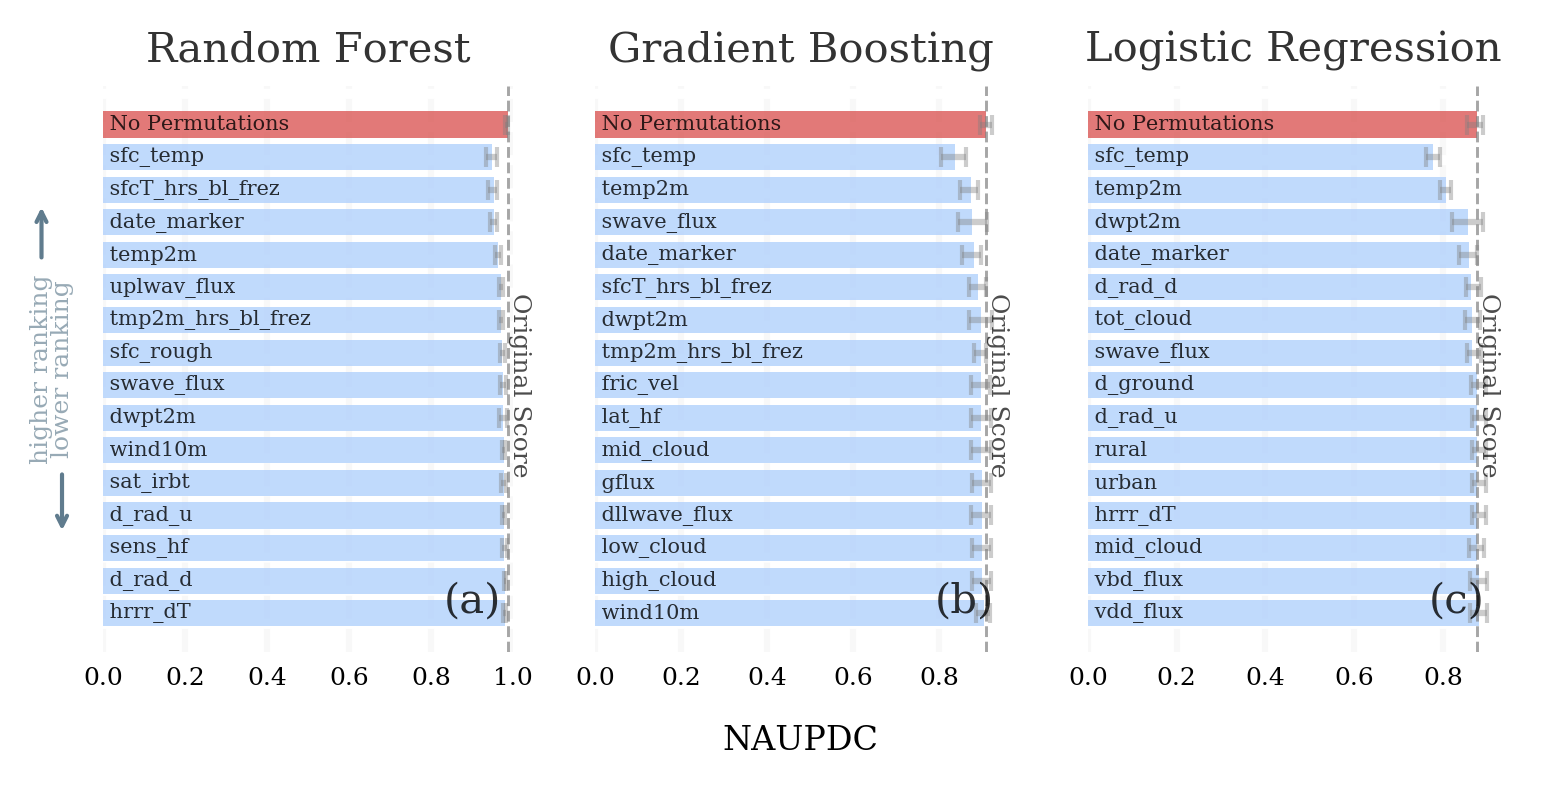

In [9]:
fig = myInterpreter.plot_importance(multipass=False, metrics_used=['NAUPDC'], num_vars_to_plot=15)

### Changing the facecolor

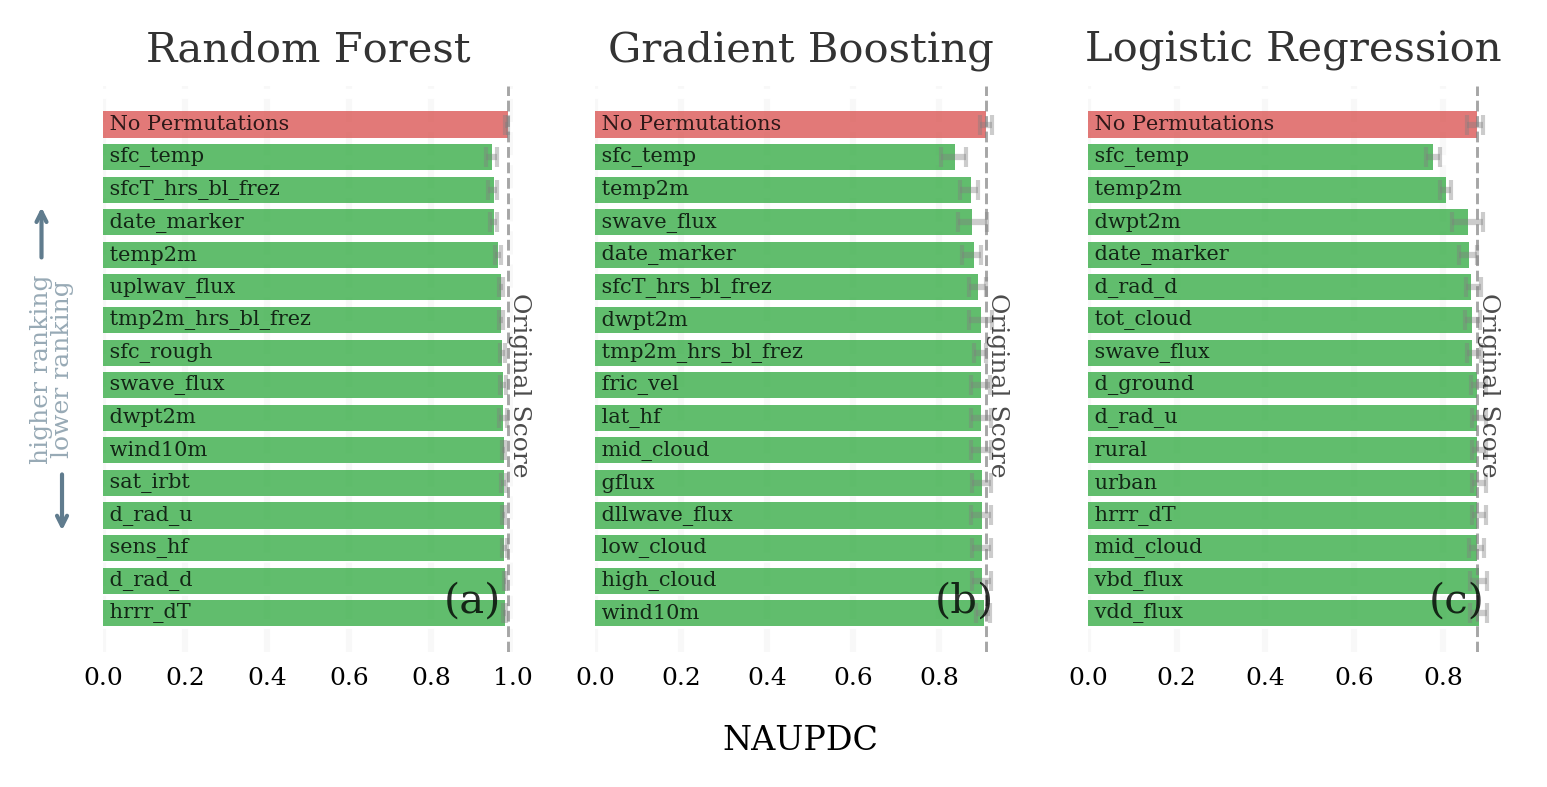

In [10]:
fig = myInterpreter.plot_importance(multipass=False, 
                                    metrics_used=['NAUPDC'], 
                                    num_vars_to_plot=15,
                                   feature_colors = 'xkcd:medium green')

## Plotting Multi-Pass Permutation Importance 

To plot the multi-pass results, set `multipass=True`. 


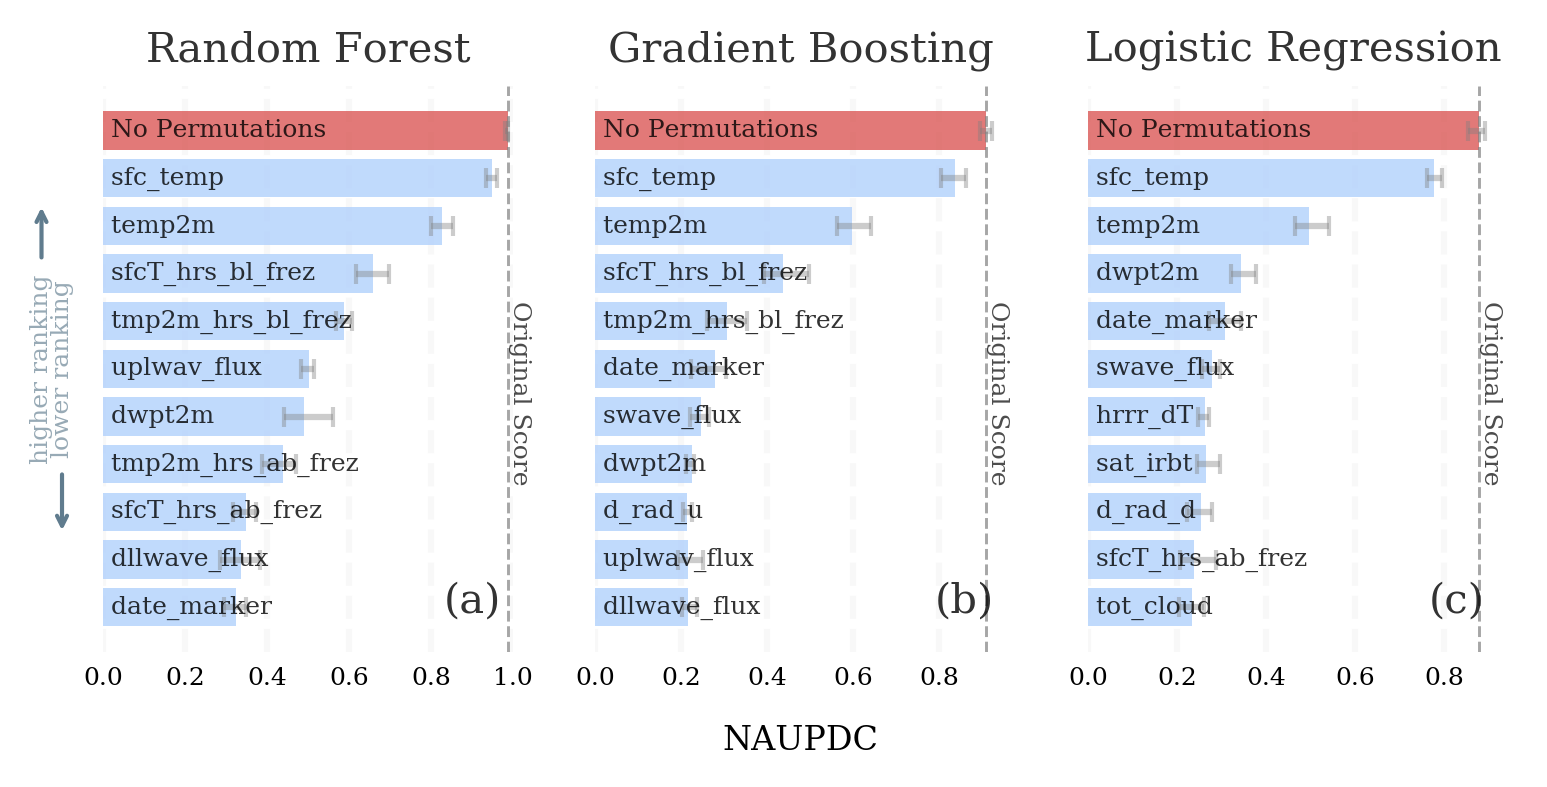

In [11]:
fig = myInterpreter.plot_importance(multipass=True, metrics_used=['NAUPDC'], num_vars_to_plot=10,)

## Plotting Permutation Importance (with Color Coding and Readable Predictor Names)

To personalize your plots, you can pass a dict `display_feature_names`, which should map the feature names with a prettier, more interpretable name. Additionally, you can color code your predictors with `feature_colors`, which maps the stored feature names to a color (see https://i.stack.imgur.com/nCk6u.jpg for a extension map of named colors in python). To see our example of `display_feature_names` and `feature_colors`, look in `plotting_config.py`. 

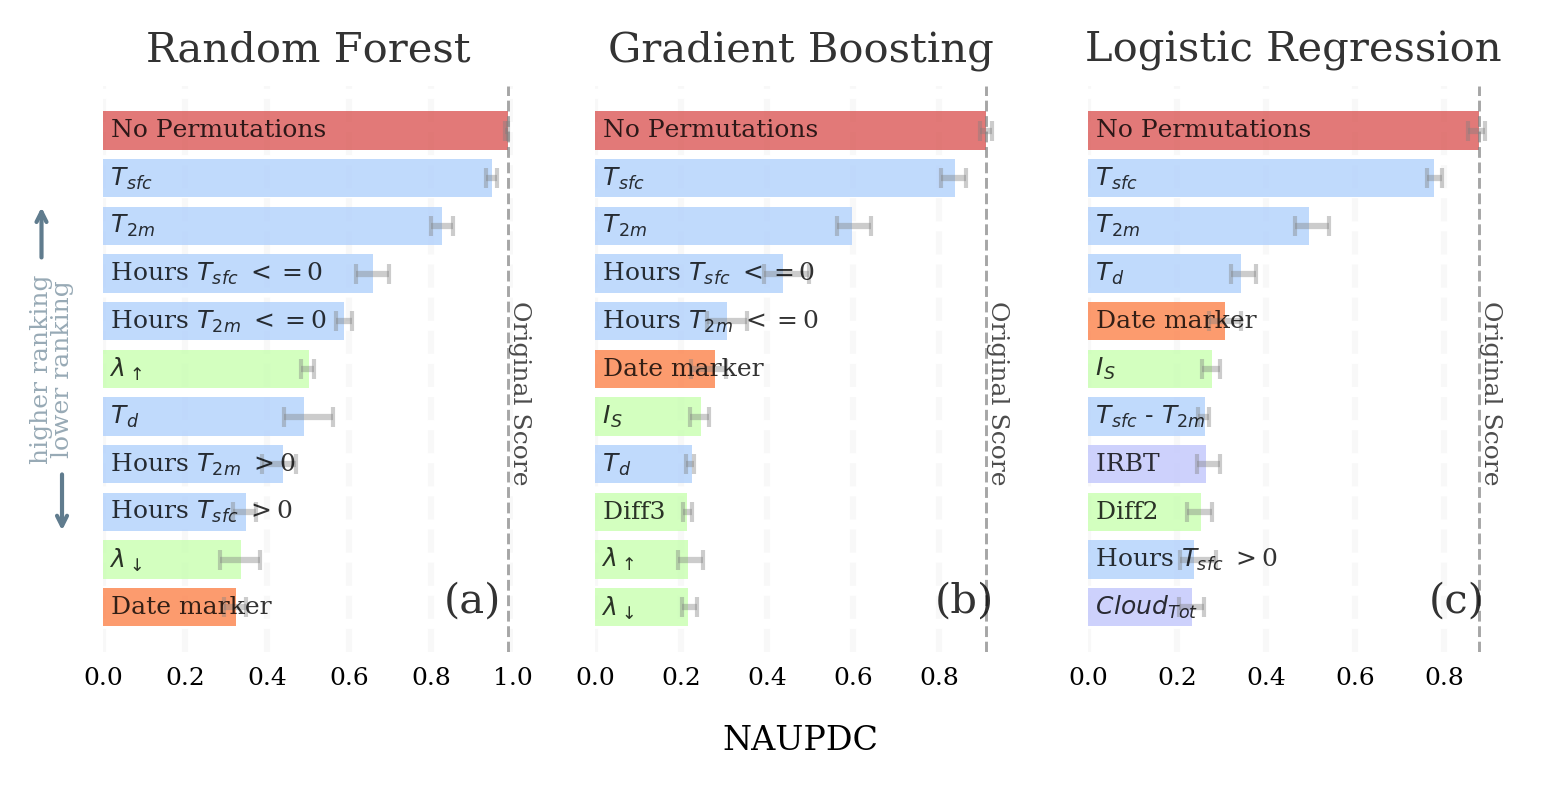

In [12]:
fig = myInterpreter.plot_importance(multipass=True, 
                                    metrics_used=['NAUPDC'], 
                                    display_feature_names=plotting_config.display_feature_names,
                                    feature_colors=plotting_config.color_dict,
                                   )

### Plotting Permutation Importance for Multiple Metrics 

The feature ranking can be sensitive to the error metric used. We can compute the permutation importance again, but this time with Area under the Precision-Recall Curve (AUPRC; also known as Area under the Performance Diagram for meteorologists). To plot results for both metrics, set `result_dict` to a list of both results. Also, to label each row, set the argument `ylabels`. In our case, We've set `ylabels = ['AUC', 'AUPRC']`.

In [13]:
"""
myInterpreter = mintpy.InterpretToolkit(models=model_objs,
                                 model_names=model_names,
                                 examples=examples,
                                 targets=targets,
                                )
auc_results = myInterpreter.calc_permutation_importance(
                                               n_vars=10, 
                                               evaluation_fn='auc', 
                                               n_bootstrap=5, 
                                               subsample=0.01,
                                               n_jobs=8
                                              )
myInterpreter.save_results(fname='multipass_importance_auc.nc',
                          data=auc_results)
"""

"\nmyInterpreter = mintpy.InterpretToolkit(models=model_objs,\n                                 model_names=model_names,\n                                 examples=examples,\n                                 targets=targets,\n                                )\nauc_results = myInterpreter.calc_permutation_importance(\n                                               n_vars=10, \n                                               evaluation_fn='auc', \n                                               n_bootstrap=5, \n                                               subsample=0.01,\n                                               n_jobs=8\n                                              )\nmyInterpreter.save_results(fname='multipass_importance_auc.nc',\n                          data=auc_results)\n"

<xarray.Dataset>
Dimensions:                                   (n_bootstrap: 5, n_vars_multipass: 10, n_vars_singlepass: 30)
Dimensions without coordinates: n_bootstrap, n_vars_multipass, n_vars_singlepass
Data variables:
    multipass_rankings__Random Forest         (n_vars_multipass) object ...
    multipass_scores__Random Forest           (n_vars_multipass, n_bootstrap) float64 ...
    singlepass_rankings__Random Forest        (n_vars_singlepass) object ...
    singlepass_scores__Random Forest          (n_vars_singlepass, n_bootstrap) float64 ...
    original_score__Random Forest             (n_bootstrap) float64 ...
    multipass_rankings__Gradient Boosting     (n_vars_multipass) object ...
    multipass_scores__Gradient Boosting       (n_vars_multipass, n_bootstrap) float64 ...
    singlepass_rankings__Gradient Boosting    (n_vars_singlepass) object ...
    singlepass_scores__Gradient Boosting      (n_vars_singlepass, n_bootstrap) float64 ...
    original_score__Gradient Boosting 

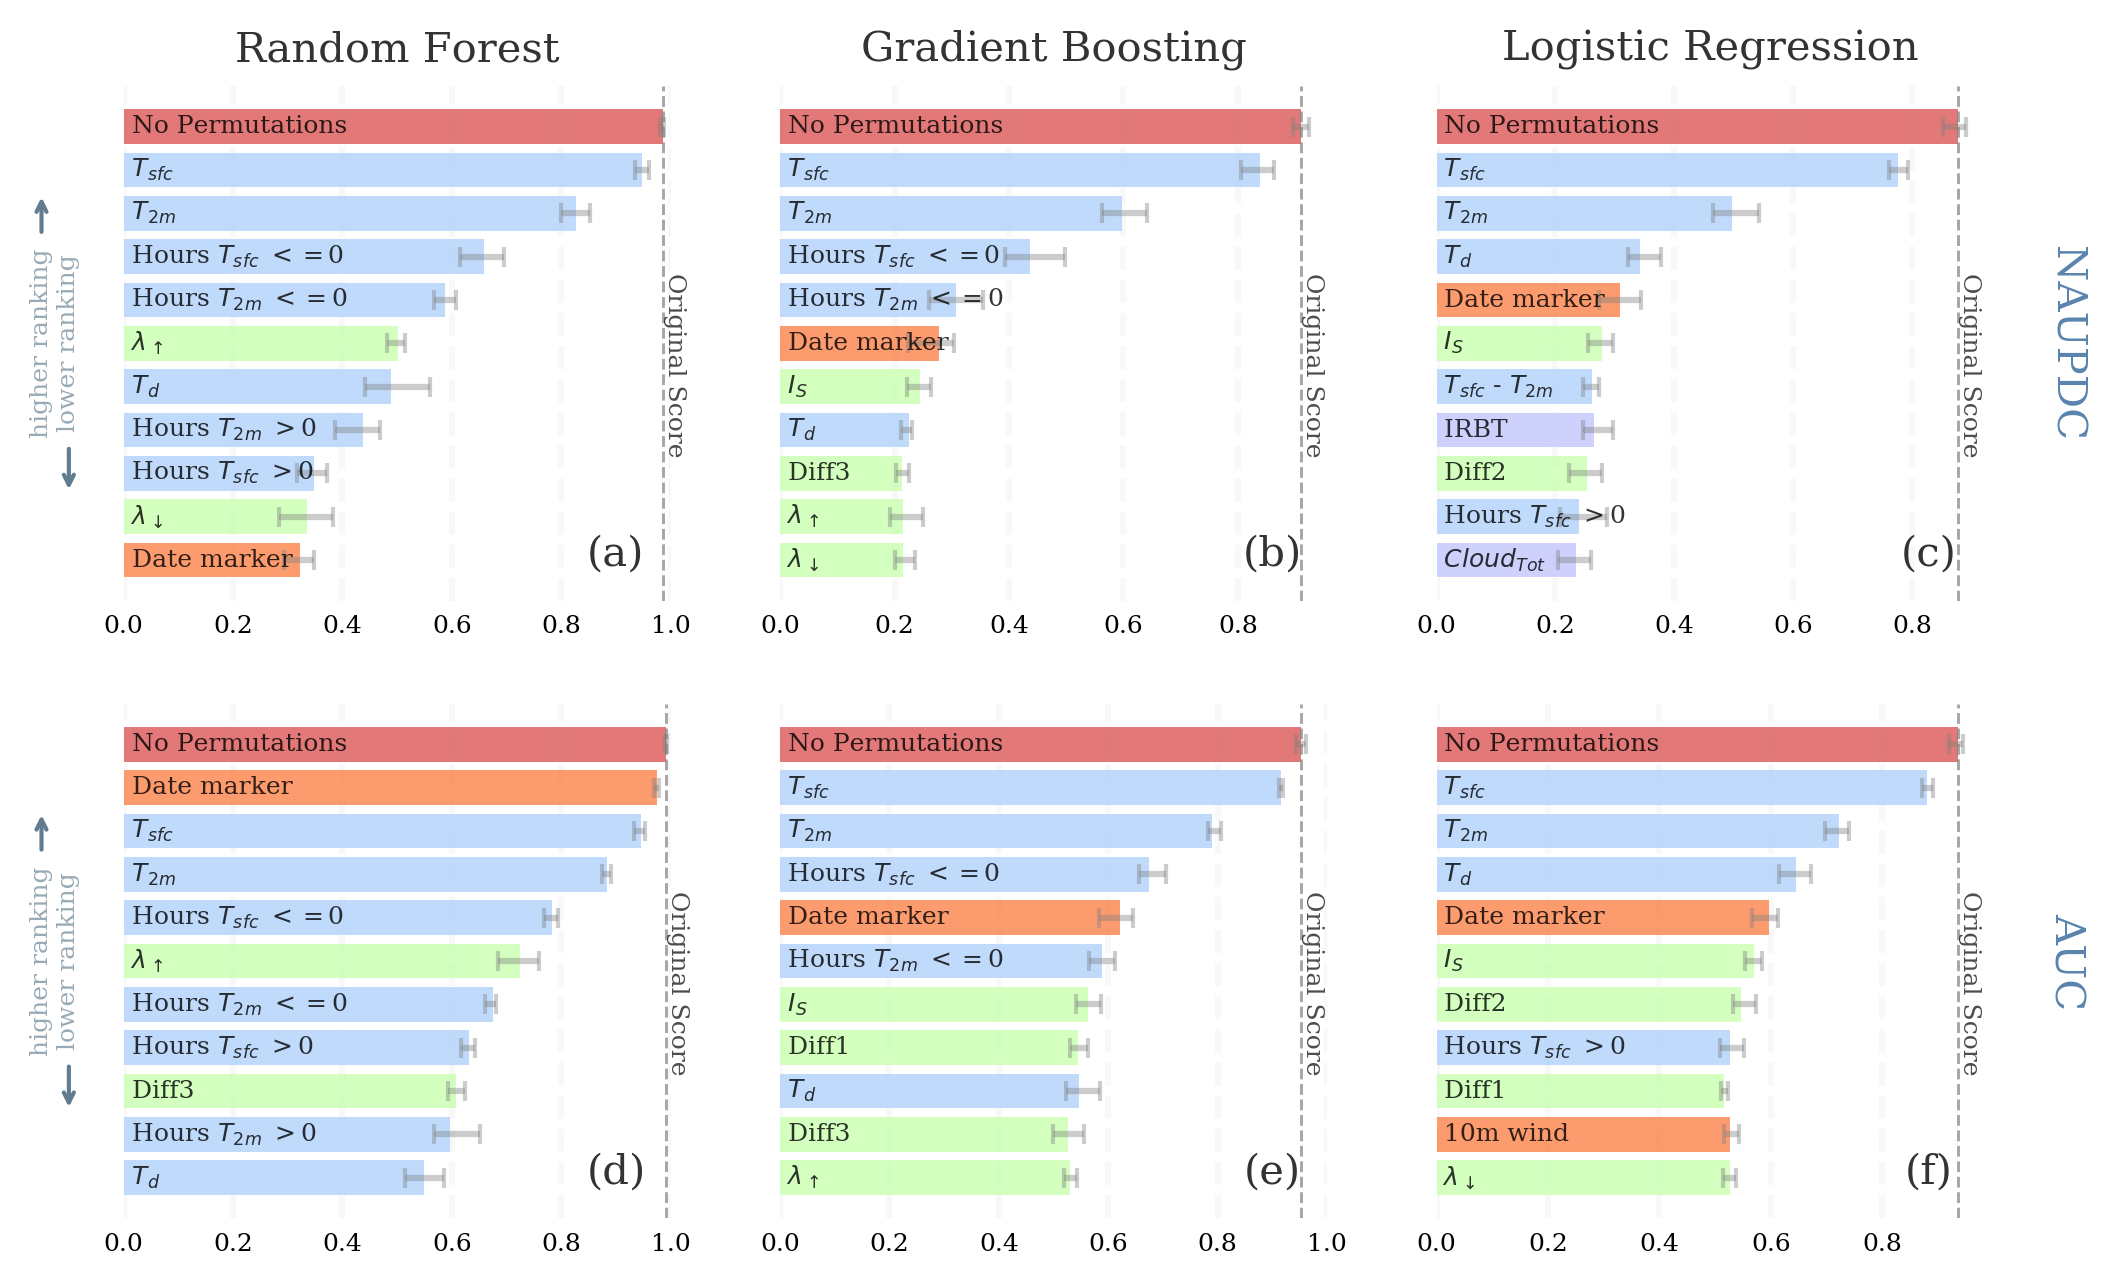

In [14]:
myInterpreter.load_results(fnames='multipass_importance_auc.nc')

auc_results = myInterpreter.perm_imp_ds

fig = myInterpreter.plot_importance(
                                    data = [results, auc_results],
                                    multipass=True, 
                                    display_feature_names=plotting_config.display_feature_names,
                                    feature_colors=plotting_config.color_dict,
                                    metrics_used = ['NAUPDC', 'AUC'],
                                    figsize = (8,5), 
                                    hspace = 0.2
                                   )

There are some differences, but overall the feature ranking are roughly similar. This bolsters our confidence in the feature ranking and helps triangulate the most important predictors. 

## Permutation Importance for Regression Problems

In [15]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor

In [16]:
data = fetch_california_housing()
X = data['data']
y = data['target']
feature_names = data['feature_names']
clf = RandomForestRegressor()
clf.fit(X,y)

RandomForestRegressor()

In [17]:
myInterpreter = mintpy.InterpretToolkit(models=clf,
                                 model_names='Random Forest',
                                 examples=X,
                                 targets=y,
                                 feature_names = feature_names
                                )
reg_results = myInterpreter.calc_permutation_importance(
                                               n_vars=8, 
                                               evaluation_fn='mse', 
                                               n_bootstrap=5, 
                                               subsample=0.5,
                                               n_jobs=8,
                                               verbose=True
                                              )

OrderedDict([('Random Forest', RandomForestRegressor())]) ['Random Forest']
Starting on the important variable 1 out of 8...
Starting on the important variable 2 out of 8...
Starting on the important variable 3 out of 8...
Starting on the important variable 4 out of 8...
Starting on the important variable 5 out of 8...
Starting on the important variable 6 out of 8...
Starting on the important variable 7 out of 8...
Starting on the important variable 8 out of 8...


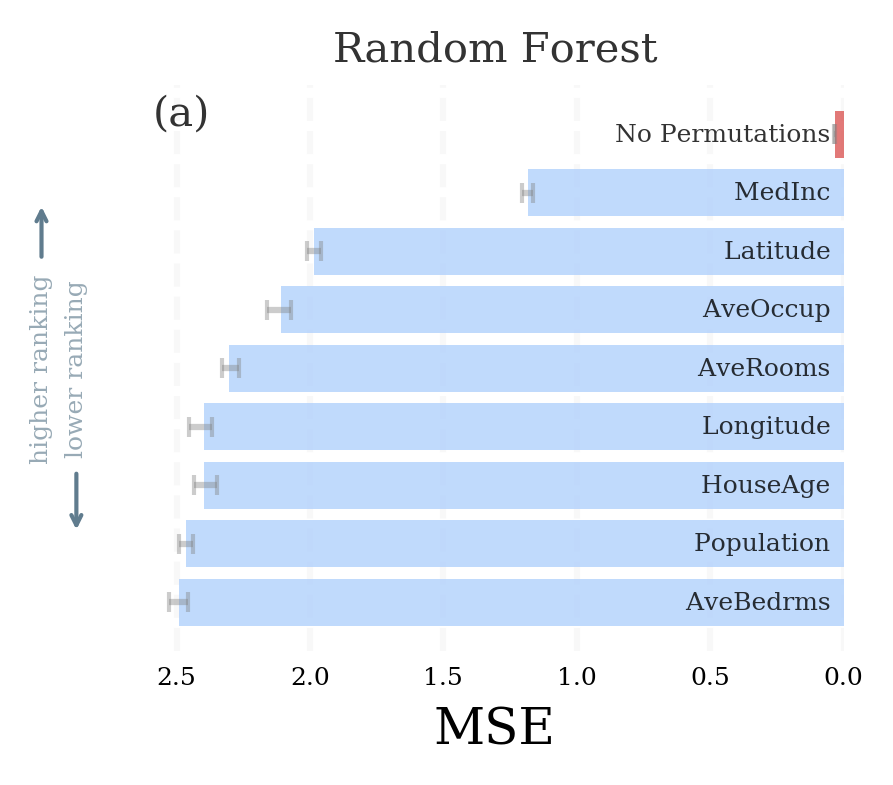

In [18]:
fig = myInterpreter.plot_importance(multipass=True, metrics_used = ["MSE"], num_vars_to_plot=8)

References: 

Handler, S. L., H. D. Reeves, and A. McGovern, Development of a Probabilistic Subfreezing Road Temperature Nowcast and Forecast Using Machine Learning. Wea. Forecasting, doi: https://doi.org/10.1175/WAF-D-19-0159.1

McGovern, A., R. Lagerquist, D. John Gagne, G. E. Jergensen, K. L. Elmore, C. R. Homeyer, and T. Smith, 2019: Making the Black Box More Transparent: Understanding the Physical Implications of Machine Learning. Bull. Amer. Meteor. Soc., 100, 2175–2199, https://doi.org/10.1175/BAMS-D-18-0195.1.